# Обучение классификатора на основе Tiny Dataset

# Импортирую библиотеки

In [1]:
import torch 
import torch.nn as nn
import torchvision
from torchsummary import summary
import warnings
from sklearn.metrics import accuracy_score

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import os

import pandas as pd
import cv2

# Работа с датасетом

In [3]:
df = pd.read_csv(os.path.join('tiny-imagenet-200/val','val_annotations.txt'),
                         sep='\t',
                         header=None)

In [4]:
df

,0,1,2,3,4,5
0,val_0.JPEG,n03444034,0,32,44,62
1,val_1.JPEG,n04067472,52,55,57,59
2,val_2.JPEG,n04070727,4,0,60,55
3,val_3.JPEG,n02808440,3,3,63,63
4,val_4.JPEG,n02808440,9,27,63,48
...,...,...,...,...,...,...
9995,val_9995.JPEG,n03085013,0,0,63,63
9996,val_9996.JPEG,n03444034,0,9,63,63
9997,val_9997.JPEG,n03424325,10,10,38,42
9998,val_9998.JPEG,n01629819,28,18,63,31


In [5]:
class DatasetCustom(torch.utils.data.Dataset):
    def __init__(self, root, ordered_classes):
        self.files = sorted(os.listdir(os.path.join(root, "images")))
        self.path = os.path.join(root, "images")

        df = pd.read_csv(os.path.join(root,'val_annotations.txt'),
                         sep='\t',
                         header=None)
        df = df[[0,1]]
        self.idx_to_class = {k:v for k,v
                             in zip(df.values[:,0], df.values[:,1])}
        self.label_dict = {j:i for i,j
                           in enumerate(ordered_classes)}

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(self.path, self.files[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128,128), interpolation = cv2.INTER_AREA)/255.

        class_id = self.idx_to_class[self.files[idx]]
        label = self.label_dict[class_id]
        return (
            torch.tensor(np.transpose(img, [2,0,1]), dtype=torch.float32),
            torch.tensor(label),
        )

    def __len__(self):
        return len(self.files)

In [6]:
train_dataset = torchvision.datasets.ImageFolder(
    './tiny-imagenet-200/train/',
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((128,128)),
            torchvision.transforms.ToTensor()
        ]
    )
)

In [7]:
val_dataset = DatasetCustom(root='./tiny-imagenet-200/val', ordered_classes=train_dataset.class_to_idx)

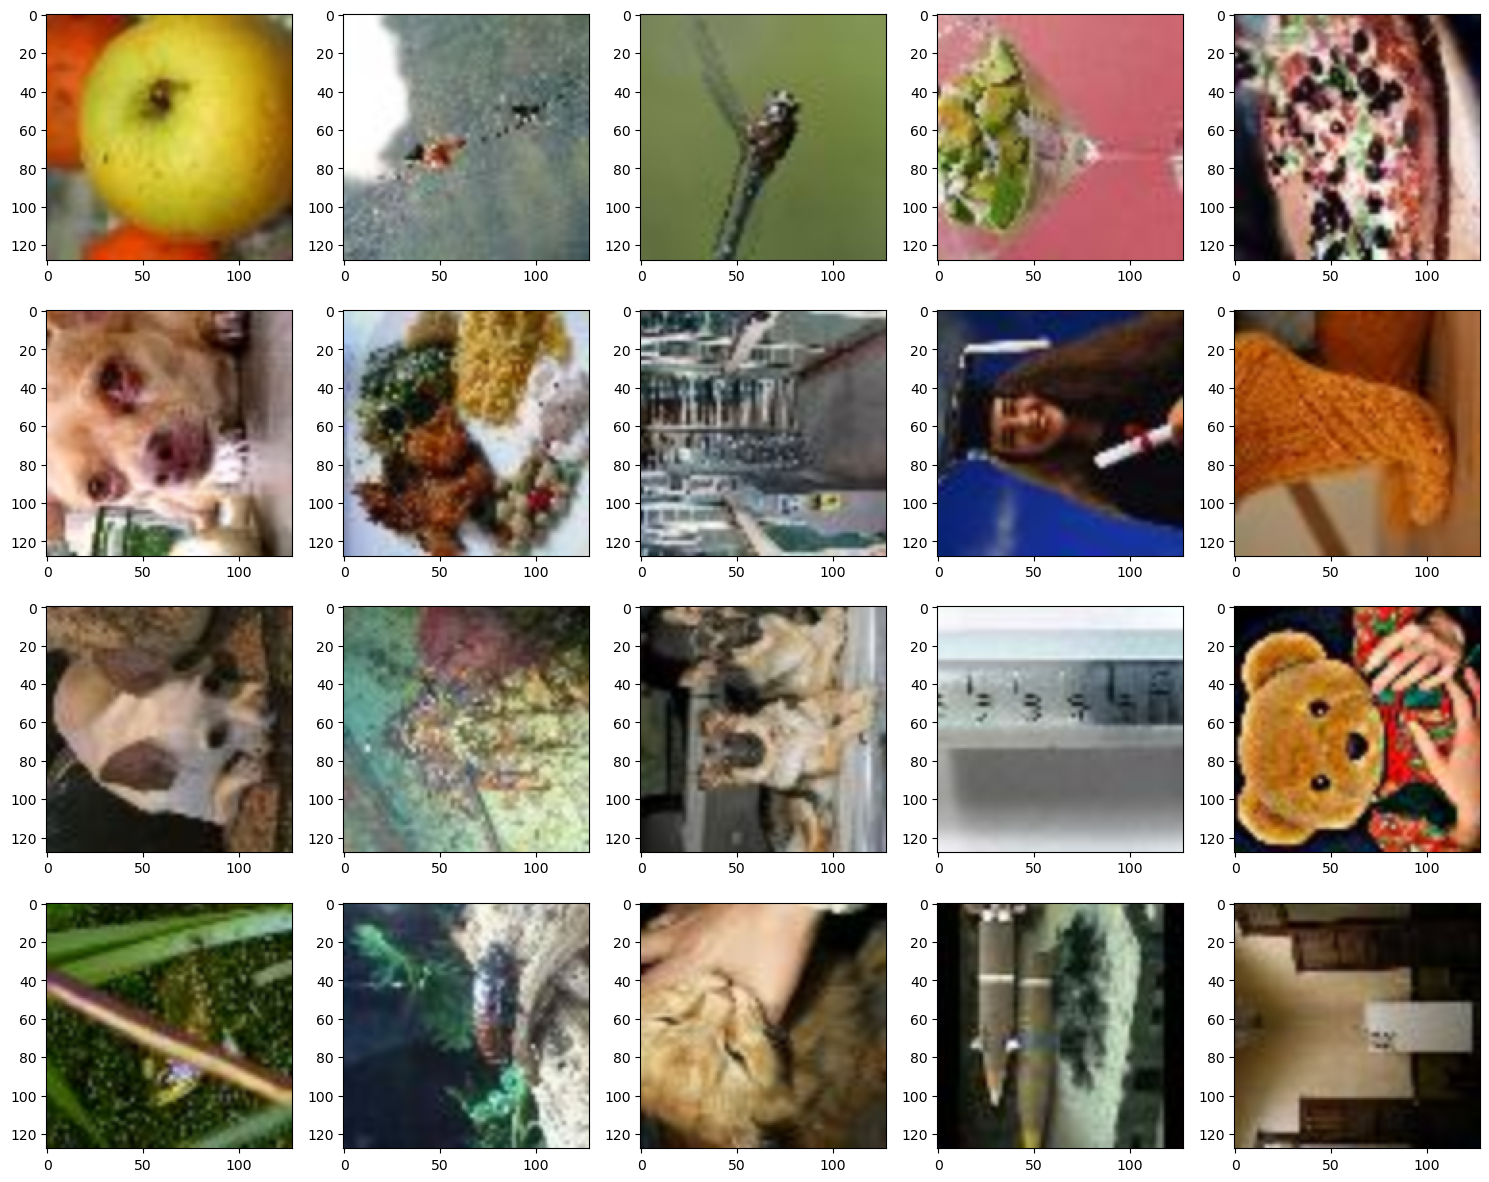

In [8]:
rows, cols  = (4,5)

axes=[]

fig=plt.figure(figsize=(15,3*rows))

indices = np.random.randint(0, len(train_dataset), rows*cols)

for a in range(rows*cols):
    axes.append( fig.add_subplot(rows, cols, a+1) )
    plt.imshow(train_dataset[indices[a]][0].numpy().T)

fig.tight_layout()
plt.show()

In [9]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    pin_memory=True,
    num_workers=2,
)

# disable shuffling
test_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    pin_memory=True,
    num_workers=2
)

In [10]:
for x,y in train_loader:
    print(x.shape, y.shape)
    break

for x,y in test_loader:
    print(x.shape, y.shape)
    break


rand_batch = torch.rand(32,3,128,128)

torch.Size([128, 3, 128, 128]) torch.Size([128])
torch.Size([128, 3, 128, 128]) torch.Size([128])



# Первая попытка

In [ ]:
Выбор Модели

In [11]:
import timm
timm.list_models("*resnet*", pretrained=True)

['cspresnet50.ra_in1k',
 'eca_resnet33ts.ra2_in1k',
 'ecaresnet26t.ra2_in1k',
 'ecaresnet50d.miil_in1k',
 'ecaresnet50d_pruned.miil_in1k',
 'ecaresnet50t.a1_in1k',
 'ecaresnet50t.a2_in1k',
 'ecaresnet50t.a3_in1k',
 'ecaresnet50t.ra2_in1k',
 'ecaresnet101d.miil_in1k',
 'ecaresnet101d_pruned.miil_in1k',
 'ecaresnet269d.ra2_in1k',
 'ecaresnetlight.miil_in1k',
 'gcresnet33ts.ra2_in1k',
 'gcresnet50t.ra2_in1k',
 'inception_resnet_v2.tf_ens_adv_in1k',
 'inception_resnet_v2.tf_in1k',
 'lambda_resnet26rpt_256.c1_in1k',
 'lambda_resnet26t.c1_in1k',
 'lambda_resnet50ts.a1h_in1k',
 'legacy_seresnet18.in1k',
 'legacy_seresnet34.in1k',
 'legacy_seresnet50.in1k',
 'legacy_seresnet101.in1k',
 'legacy_seresnet152.in1k',
 'nf_resnet50.ra2_in1k',
 'resnet10t.c3_in1k',
 'resnet14t.c3_in1k',
 'resnet18.a1_in1k',
 'resnet18.a2_in1k',
 'resnet18.a3_in1k',
 'resnet18.fb_ssl_yfcc100m_ft_in1k',
 'resnet18.fb_swsl_ig1b_ft_in1k',
 'resnet18.gluon_in1k',
 'resnet18.tv_in1k',
 'resnet18d.ra2_in1k',
 'resnet26.bt_i

In [12]:
model = timm.create_model('resnet26t')

In [13]:
summary(model, (3,256,256), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 128, 128]             648
       BatchNorm2d-2         [-1, 24, 128, 128]              48
              ReLU-3         [-1, 24, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           6,912
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              ReLU-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 64, 128, 128]          18,432
       BatchNorm2d-8         [-1, 64, 128, 128]             128
              ReLU-9         [-1, 64, 128, 128]               0
        MaxPool2d-10           [-1, 64, 64, 64]               0
           Conv2d-11           [-1, 64, 64, 64]           4,096
      BatchNorm2d-12           [-1, 64, 64, 64]             128
             ReLU-13           [-1, 64, 64, 64]               0
           Conv2d-14           [-1, 64,

In [14]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

Задам полносвязный слой

In [15]:
model.fc=nn.Sequential(nn.Linear(in_features=2048, out_features=1024, bias=True),
         nn.Dropout(0.35),
         nn.ReLU(),
         nn.Linear(in_features=1024, out_features=512, bias=True),
         nn.Dropout(0.15),
         nn.ReLU(),
         nn.Linear(in_features=512, out_features=200, bias=True))
#model.add(nn.Linear(in_features=1024, out_features=512, bias=True))
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): Dropout(p=0.35, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): Dropout(p=0.15, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=200, bias=True)
)

In [16]:
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Co

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
warnings.filterwarnings("ignore")

In [18]:
def accuracy_score_gpu(y_true, y_pred):
    return ((y_true==y_pred).sum()/y_true.shape[0]).item()

In [25]:
epochs = 10
for i in range(epochs):
    model.train()

    for j, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        x = x
        y = y
        y_pred = model(x)
        loss = criterion(y_pred, y)
        acc = accuracy_score_gpu(y, y_pred.detach().argmax(dim=1))
        if j%20 == 0:
            print(f"Epoch {i:3}\t iter {j:3}\t loss {loss:1.4}\t acc {acc:1.4}")
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        for j, (x, y) in enumerate(test_loader):
            x = x
            y = y
            y_pred = model(x)
            loss = criterion(y_pred, y)
            acc = accuracy_score_gpu(y, y_pred.argmax(dim=1))
            if j%20==0:
                print(f"Epoch {i:3}\t iter {j:3}\t val_loss {loss:1.4}\t val_acc {acc:1.4}")
print("end")

Epoch   0	 iter   0	 loss 5.287	 acc 0.0
Epoch   0	 iter  20	 loss 5.298	 acc 0.01562
Epoch   0	 iter  40	 loss 5.263	 acc 0.02344
Epoch   0	 iter  60	 loss 5.239	 acc 0.01562
Epoch   0	 iter  80	 loss 5.205	 acc 0.04688
Epoch   0	 iter 100	 loss 5.186	 acc 0.03906
Epoch   0	 iter 120	 loss 5.215	 acc 0.01562
Epoch   0	 iter 140	 loss 5.139	 acc 0.007812
Epoch   0	 iter 160	 loss 5.171	 acc 0.01562
Epoch   0	 iter 180	 loss 5.08	 acc 0.007812
Epoch   0	 iter 200	 loss 4.997	 acc 0.05469
Epoch   0	 iter 220	 loss 5.0	 acc 0.02344
Epoch   0	 iter 240	 loss 4.965	 acc 0.03125
Epoch   0	 iter 260	 loss 4.913	 acc 0.05469
Epoch   0	 iter 280	 loss 4.857	 acc 0.07031
Epoch   0	 iter 300	 loss 4.845	 acc 0.07812
Epoch   0	 iter 320	 loss 4.74	 acc 0.0625
Epoch   0	 iter 340	 loss 4.72	 acc 0.07812
Epoch   0	 iter 360	 loss 4.609	 acc 0.07031
Epoch   0	 iter 380	 loss 4.632	 acc 0.05469
Epoch   0	 iter 400	 loss 4.575	 acc 0.09375
Epoch   0	 iter 420	 loss 4.725	 acc 0.03906
Epoch   0	 iter 44

# Результаты первой попытки

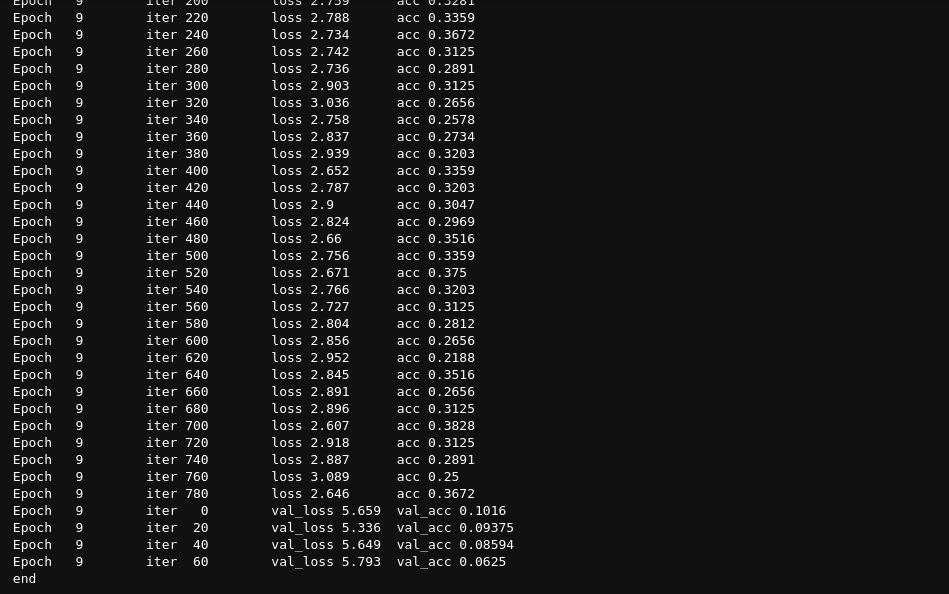
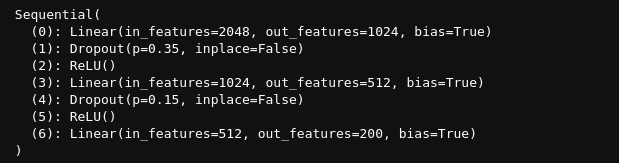
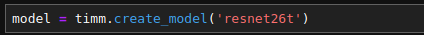

Итоговая точность 10% (тренировал на cpu часов 8) ((((

# Потом была попытка в colab на cpu

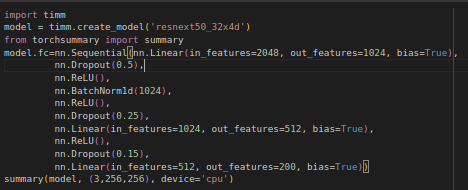

Обучение шло медленно и спустя несколько часов стало понятно что в принципе и не шло (
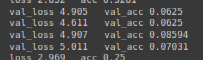

Ресурсы colab кончились после эксперимента с resnet 101 после этого вернулся на cpu

# Следующая попытка

Решил сделать максимально простой вариант с минимальным числом слоев в полносвязной части

In [42]:
model1 = timm.create_model('resnet18')
#summary(model, (3,256,256), device='cpu')
model1.fc

Linear(in_features=512, out_features=1000, bias=True)

In [51]:
model1.fc=nn.Sequential(
         nn.BatchNorm1d(512),
         nn.Linear(in_features=512, out_features=200, bias=True))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=5e-5)
warnings.filterwarnings("ignore")

In [50]:
epochs = 150
for i in range(epochs):
    model1.train()

    for j, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        x = x
        y = y
        y_pred = model1(x)
        loss = criterion(y_pred, y)
        acc = accuracy_score_gpu(y, y_pred.detach().argmax(dim=1))
        if j%20 == 0:
            print(f"Epoch {i:3}\t iter {j:3}\t loss {loss:1.4}\t acc {acc:1.4}")
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        for j, (x, y) in enumerate(test_loader):
            x = x
            y = y
            y_pred = model1(x)
            loss = criterion(y_pred, y)
            acc = accuracy_score_gpu(y, y_pred.argmax(dim=1))
            if j%20==0:
                print(f"Epoch {i:3}\t iter {j:3}\t val_loss {loss:1.4}\t val_acc {acc:1.4}")
print("end")

Epoch   0	 iter   0	 loss 3.584	 acc 0.2656
Epoch   0	 iter  20	 loss 3.706	 acc 0.2266
Epoch   0	 iter  40	 loss 3.67	 acc 0.2031
Epoch   0	 iter  60	 loss 3.679	 acc 0.1875
Epoch   0	 iter  80	 loss 3.644	 acc 0.2344
Epoch   0	 iter 100	 loss 3.735	 acc 0.1875
Epoch   0	 iter 120	 loss 3.884	 acc 0.1562
Epoch   0	 iter 140	 loss 3.597	 acc 0.2109
Epoch   0	 iter 160	 loss 3.781	 acc 0.1797
Epoch   0	 iter 180	 loss 3.59	 acc 0.2109
Epoch   0	 iter 200	 loss 3.75	 acc 0.1719
Epoch   0	 iter 220	 loss 3.752	 acc 0.1719
Epoch   0	 iter 240	 loss 3.734	 acc 0.2266
Epoch   0	 iter 260	 loss 3.694	 acc 0.2031
Epoch   0	 iter 280	 loss 3.545	 acc 0.2891
Epoch   0	 iter 300	 loss 3.848	 acc 0.1953
Epoch   0	 iter 320	 loss 3.608	 acc 0.2344
Epoch   0	 iter 340	 loss 3.482	 acc 0.2812
Epoch   0	 iter 360	 loss 3.398	 acc 0.25
Epoch   0	 iter 380	 loss 3.653	 acc 0.2266
Epoch   0	 iter 400	 loss 3.781	 acc 0.1797
Epoch   0	 iter 420	 loss 3.488	 acc 0.2578
Epoch   0	 iter 440	 loss 3.564	 acc 

KeyboardInterrupt: 

# Итог

Подход эффективней всех предыдущих, но не хватило времени . В данный момент прошло 3 эпохи и точность=14 % что уже лучше всех остальных попыток